###In-Class Exercise: Stock Class (in_class_4_str.py)

In [33]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb

!pip install yfinance

import yfinance as yf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     -------------------------------------- 949.2/949.2 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 21.5 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15617 sha256=b3f21a35fa02250272cb7eb5f2a34ff1757ca221521f9ffe9f5b90b3df9dfebf
  Stored in directory: c:\users\tavis\appdata\local\pip\cache\wheels\cc\bd\6f\664d62c99327abeef7d86489e663

In [34]:
# ===== Visualization Defaults =====
sb.set_theme(style="whitegrid", context="talk")

# ===== Constants =====
DEFAULT_START = dt.date.isoformat(dt.date.today() - dt.timedelta(365))
DEFAULT_END = dt.date.isoformat(dt.date.today())

Price            close    change instant_return
Ticker            NVDA                         
date                                           
2024-10-07  127.720001       NaN            NaN
2024-10-08  132.889999  5.169998         0.0397
2024-10-09  132.649994 -0.240005        -0.0018
2024-10-10  134.809998  2.160004         0.0162
2024-10-11  134.800003 -0.009995        -0.0001


C:\Users\tavis\AppData\Local\Temp\ipykernel_11568\806810649.py:99: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base = float(close.iloc[0])


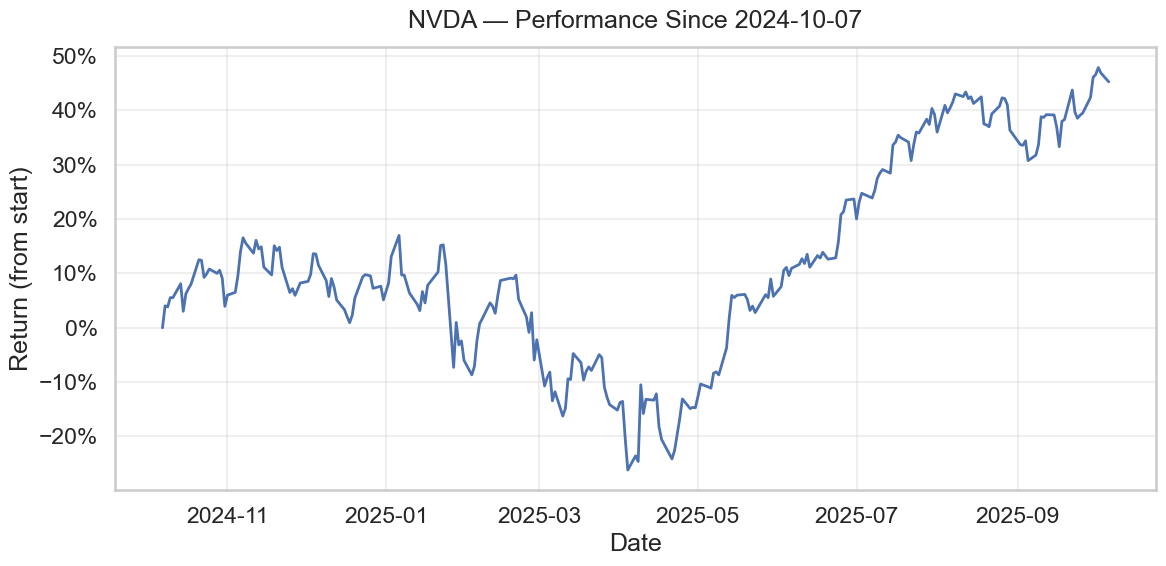

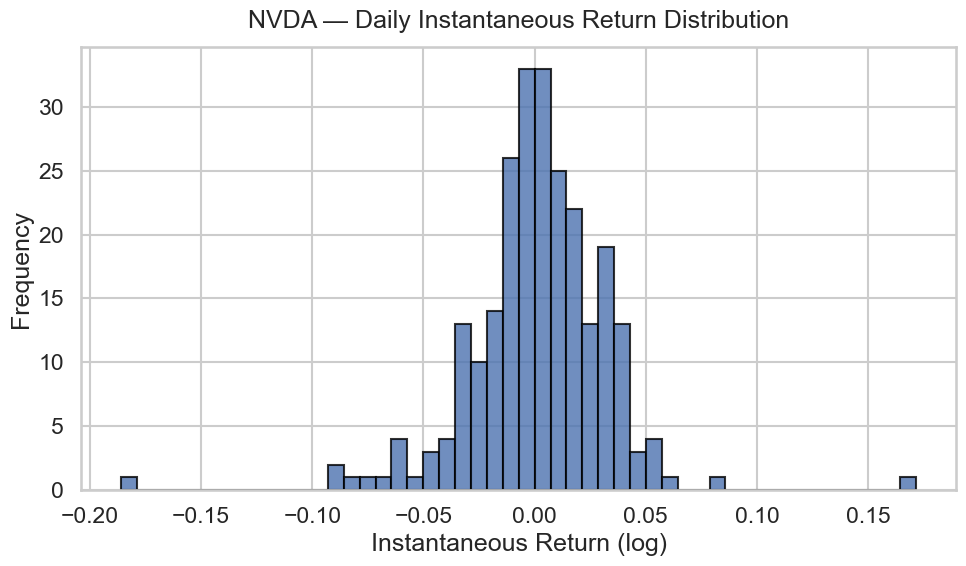

In [38]:
# ===== Class Definition =====
class Stock:
    def __init__(self, symbol: str, start: str = DEFAULT_START, end: str = DEFAULT_END):
        """
        Parameters
        ----------
        symbol : str
            Ticker string, e.g., 'AAPL'
        start : str
            ISO date 'YYYY-MM-DD' (defaults to 1 year ago)
        end : str
            ISO date 'YYYY-MM-DD' (defaults to today)
        """
        if not isinstance(symbol, str):
            raise ValueError("symbol must be a string ticker, e.g., 'AAPL'")
        self.symbol = symbol.upper()
        self.start = start
        self.end = end
        self.data = self.get_data()

    def get_data(self) -> pd.DataFrame:
        """
        Download historical OHLCV data via yfinance and store in a pandas DataFrame.
        - Index set to DatetimeIndex named 'date'
        - Keep a 'close' column (float)
        - Enrich with 'change' and 'instant_return' via calc_returns()
        """
        raw = yf.download(
            self.symbol,
            start=self.start,
            end=self.end,
            interval="1d",
            auto_adjust=False,
            progress=False,
            threads=True,
        )

        if raw is None or raw.empty:
            raise ValueError(f"No data returned for {self.symbol} between {self.start} and {self.end}.")

        data = raw.copy()
        data.index = pd.to_datetime(data.index)
        data.index.name = "date"

        # Standardize the close column
        if "Close" in data.columns:
            data = data[["Close"]].rename(columns={"Close": "close"}).astype(float)
        else:
            close_candidates = [c for c in data.columns if c.lower() == "close"]
            if not close_candidates:
                raise ValueError("Downloaded data does not include a 'Close' column.")
            data = data[[close_candidates[0]]].rename(columns={close_candidates[0]: "close"}).astype(float)

        # Enrich with change & instant_return
        self.calc_returns(data)

        self.data = data
        return data

    def calc_returns(self, df: pd.DataFrame) -> None:
        """
        Helper to add:
        - change: close-to-close dollar change vs. prior day
        - instant_return: daily log return, rounded to 4 decimals
          np.log(close).diff().round(4)
        """
        if "close" not in df.columns:
            raise ValueError("DataFrame must contain a 'close' column before calc_returns().")

        df["change"] = df["close"].diff()
        df["instant_return"] = np.log(df["close"]).diff().round(4)

    def plot_return_dist(self, bins: int = 50) -> None:
        """Plot histogram of instantaneous (log) returns."""
        if self.data is None or self.data.empty:
            raise ValueError("No data to plot. Instantiate the object or call get_data first.")

        returns = self.data["instant_return"].dropna()
        if returns.empty:
            raise ValueError("instant_return series is empty; cannot plot distribution.")

        plt.figure(figsize=(10, 6))
        plt.hist(returns.values, bins=bins, edgecolor="black", alpha=0.8)
        plt.title(f"{self.symbol} — Daily Instantaneous Return Distribution", pad=14)
        plt.xlabel("Instantaneous Return (log)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    def plot_performance(self) -> None:
        """Plot cumulative performance as percent gain/loss from the first close in the sample."""
        if self.data is None or self.data.empty:
            raise ValueError("No data to plot. Instantiate the object or call get_data first.")

        close = self.data["close"].dropna()
        if close.empty:
            raise ValueError("No 'close' prices available for performance plot.")

        base = float(close.iloc[0])
        series = (close / base) - 1.0  # decimal return from baseline

        fig = plt.figure(figsize=(12, 6))
        ax = fig.gca()
        ax.plot(series.index, series.values, linewidth=2)

        ax.set_title(f"{self.symbol} — Performance Since {series.index[0].date().isoformat()}", pad=14)
        ax.set_xlabel("Date")
        ax.set_ylabel("Return (from start)")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.grid(True, which="major", alpha=0.3)
        fig.tight_layout()
        plt.show()


# ===== Test Harness =====
def main():
    test = Stock(symbol="NVDA")
    print(test.data.head())
    test.plot_performance()
    test.plot_return_dist()


if __name__ == "__main__":
    main()